# Station Travel Times of Westcoast Earthquake Early Warning Stations

### Ran at following commit levels
MagD commit https://github.com/pnsn/magD/tree/v2.1

magd_client commit https://github.com/pnsn/magd_client/tree/v2.2

## Create csv of all sites

Must have the following headers:
* net
* sta
* chan
* location
* lat
* lon
* rate*

*sample rate(not required)


## Clean CSV

ShakeAlert Coordinator provided two xls files, one current west coast eew, on notional west coast eew. Since this is densisty problem, location, and chan are disregarded. Both files were edited in Excel, where the headers were renamed and the following columns were added to prevent errrors:
* chan
* location
* rate
These files were then saved as CSV to 
* ./csv/west_coast/current-3-27-2019.csv 
* ./csv/west_coast/notional-3-27-2019.csv

In [ ]:
%run scripts/clean_csv.py -i csv/eew_density/eew_stas_current_all.csv -o csv/eew_density/eew_stas_current_clean.csv

In [17]:
from magD.magD import MagD
from magD.pickle import get_pickle
import os

magd_client_path = '/Users/joncon/Sites/magd_client/'
pickle_path = magd_client_path + "/pickle_jar"
os.chdir(magd_client_path)
print('Working in ' + os.getcwd())

# lat_min=29.0
lat_min=48 # test
lat_max=54.0
# lon_min=-131.0
lon_min=-118.0 #test
lon_max=-112.0

resolution=2
#number of stations to use in solution. 
num_solutions=4

# wave velocities
velocity_p = 5.0
depth = 0



data_srcs ={'west_coast_current':
                {
                    'csv_path':'csv/west_coast/existing-3-27-2019.csv',
                    'color': 'yellow',
                    'symbol': '^',
                    'size': 50,
                    'label': "Current",
                    'unit': 'Km',
                    'klass': 'scnl'
                },
            'west_coast_notional':
                {
                    'csv_path':'csv/west_coast/notional-3-27-2019.csv',
                    'color': 'red',
                    'symbol': '^',
                    'size': 50,
                    'label': "Notional",
                    'unit': 'seconds',
                    'klass': 'scnl'
                },
                
            }

'''if needed, overide default marker attrs and save to avoid rerunning plot
magD_object.markers['west_coast_existing']['color']='yellow'
magD_object.markers['west_coast_existing']['symbol']='o'
magD_object.markers['west_coast_existing']['size']=10
magD_object.save()'''

def make_grid(grid_type, src, lat_min=lat_min, lat_max=lat_max, lon_min=lon_min, lon_max=lon_max):
    grid = MagD(grid_type, name, resolution, lat_min, lat_max, lon_min, lon_max, 
                   num_solutions, pickle_path)
    grid.build_markers(src)
    grid.build_origins()
    grid.build_matrix()
    grid.save()
    return grid


Working in /Users/joncon/Sites/magd_client


In [2]:
#only run once
import os
os.chdir(magd_client_path)
print('Working in ' + magd_client_path)
from magD.pickle import *
#set book to autoreload
%load_ext autoreload
%autoreload 2
%matplotlib inline

Working in /Users/joncon/Sites/magd_client/


## Create and save MapGrids for current

In [32]:
#name of config file in ./config/{name}.ini
name ="west_coast_distance"

grid_type = 'dist_max'

src = {}
src['west_coast_current'] = data_srcs['west_coast_current']
%time wc_current_distances = make_grid(grid_type, src)


Profiling spatially...
lat: 48.0, 50.0, 52.0, CPU times: user 765 ms, sys: 4.59 ms, total: 769 ms
Wall time: 769 ms


## Trasform current distances to time

In [45]:
print(wc_current.matrix)
# travel_times param is just what to name pickle folder
wc_current_travel_times = wc_current_distances.copy("travel_times")
wc_current_travel_times.transform_to_s_travel_time(velocity_p, depth)
wc_current_travel_times.save()
print("--------------------------")
print(wc_current_travel_times.matrix)
print(wc_current_and_notional_travel_times.get_path())

[[  14.28554774   34.17608771   63.85909026]
 [  48.95648656   57.15001753   79.25378352]
 [  80.39019739   93.84907827  109.41711026]]
--------------------------
[[  25.11501541   48.61076201   70.74992745]
 [  48.95648656   60.66005652   85.67020354]
 [  80.39019739   93.84907827  111.52403684]]
/Users/joncon/Sites/magd_client//pickle_jar/travel_times/travel_times_grid/3x3-res-2.pickle


## Create and save MapGrids for current and notional

In [34]:
#name of config file in ./config/{name}.ini
name ="west_coast_current_and_notional"

grid_type = 'dist_max'

src = {}
src['west_coast_current'] = data_srcs['west_coast_current']
src['west_coast_notional'] = data_srcs['west_coast_notional']
%time wc_current_and_notional_distances = make_grid(grid_type, src)


Profiling spatially...
lat: 48.0, 50.0, 52.0, CPU times: user 2.89 s, sys: 11 ms, total: 2.9 s
Wall time: 2.91 s


# Transform current and notional to travel times

In [46]:
print(wc_current_and_notional_distances.matrix)
# travel_times param is just what to name pickle folder
wc_current_and_notional_travel_times = wc_current_and_notional_distances.copy("travel_times")
wc_current_and_notional_travel_times.transform_to_s_travel_time(velocity_p, depth)
wc_current_and_notional_travel_times.save()
print("--------------------------")
print(wc_current_and_notional_travel_times.matrix)
print(wc_current_and_notional_travel_times.get_path())

[[  71.42773871  170.88043855  319.29545132]
 [ 244.78243278  285.75008766  396.26891759]
 [ 401.95098693  469.24539134  547.0855513 ]]
--------------------------
[[  14.28554774   34.17608771   63.85909026]
 [  48.95648656   57.15001753   79.25378352]
 [  80.39019739   93.84907827  109.41711026]]
/Users/joncon/Sites/magd_client//pickle_jar/travel_times/travel_times_grid/3x3-res-2.pickle


In [31]:
# diff of notional and existing
# pass into args
# type: the catoregory with will also be the folder of pickle file
# name: name of pickle file

diff_wc_travel_times = wc_current_and_notional_travel_times.copy("diff_west_coast_travel_times")
diff_wc_travel_times.matrix = wc_current_travel_times.matrix - wc_current_and_notional_travel_times.matrix
diff_wc_travel_times.save()
print(diff_wc_travel_times.get_path())

/Users/joncon/Sites/magd_client//pickle_jar/diff_west_coast_travel_times/diff_west_coast_travel_times_grid/3x3-res-2.pickle


In [36]:
# use this to reinstantiate obj from pickle if you start a new session
wc_current = get_pickle( \
    "/Users/joncon/Sites/magd_client//pickle_jar/travel_times/travel_times_grid/3x3-res-2.pickle")
wc_current_and_notional = get_pickle( \
    "/Users/joncon/Sites/magd_client//pickle_jar/travel_times/travel_times_grid/3x3-res-2.pickle")
diff_wc = get_pickle( \
    "/Users/joncon/Sites/magd_client//pickle_jar/diff_west_coast_travel_times/diff_west_coast_travel_times_grid/3x3-res-2.pickle")

/Users/joncon/anaconda3/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1508: UserWarning: The following kwargs were not used by contour: 'vmim'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)


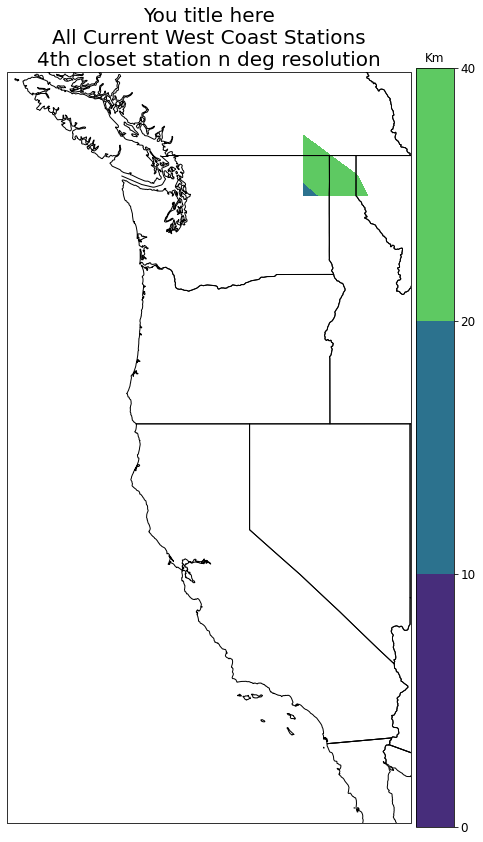

<Figure size 432x288 with 0 Axes>

In [37]:
# lat_min=29.0
# lat_max=54.0
# lon_min=-131.0
# lon_max=-112.0


path = wc_current_travel_times.get_path()
%run -i scripts/plot_heatmap.py \
--path=$path \
--title1="You title here" \
--title2="All Current West Coast Stations" \
--title3="4th closet station n deg resolution" \
--color=viridis \
--levels=0,10,20,40 \
--lat_min=30 \
--lat_max=51 \
--lon_min=-129 \
--lon_max=-114 \
--plotwidth=8 \
--plotheight=30 \
--legend_pad=0 \
--colorbar_pad=0.01 \
--colorbar_fraction=0.085 \
--unit='Km'




#--plotstas=True \

shitfuck
Namespace(color='viridis', colorbar_fraction='0.085', colorbar_pad='0.01', depth=0, lat_max='51', lat_min='30', legend_pad='0', levels='0,10,20,40', lon_max='-114', lon_min='-129', nbins=10, path='/Users/joncon/Sites/magd_client//pickle_jar/travel_times/travel_times_grid/3x3-res-2.pickle', plot_max=None, plot_min=None, plotheight='30', plotstas=False, plotwidth='8', title1='Your title here', title2='All Current and Notional West Coast Stations', title3='4th closet station 0.1 deg resolution', unit='Km', velocity_p=None, velocity_s=None)


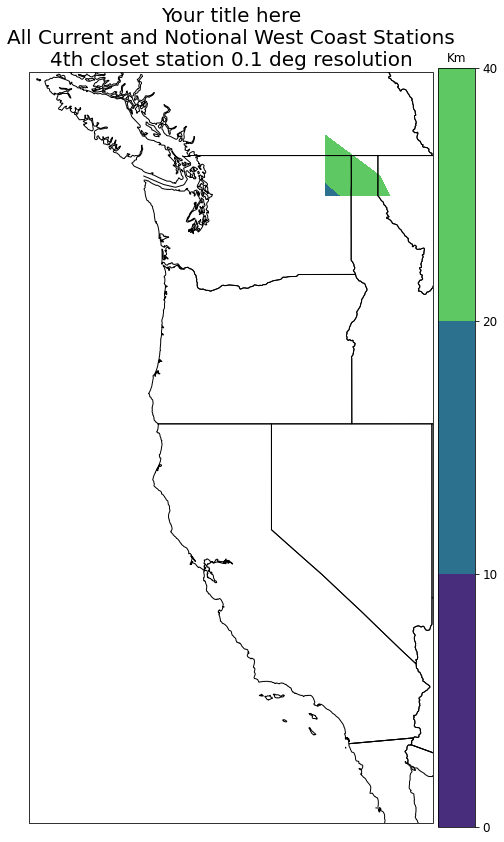

<Figure size 432x288 with 0 Axes>

In [54]:
path = wc_current_and_notional_travel_times.get_path()
%run -i scripts/plot_heatmap.py \
--path=$path \
--title1="Your title here" \
--title2="All Current and Notional West Coast Stations" \
--title3="4th closet station 0.1 deg resolution" \
--color=viridis \
--levels=0,10,20,40 \
--lat_min=30 \
--lat_max=51 \
--lon_min=-129 \
--lon_max=-114 \
--plotwidth=8 \
--plotheight=30 \
--legend_pad=0 \
--colorbar_pad=0.01 \
--colorbar_fraction=0.085 \
--unit='Km'

shitfuck
Namespace(color='viridis', colorbar_fraction=0.1, colorbar_pad=0.2, depth=0, lat_max='51', lat_min='30', legend_pad='0', levels=None, lon_max='-114', lon_min='-129', nbins=10, path='/Users/joncon/Sites/magd_client//pickle_jar/travel_times/travel_times_grid/3x3-res-2.pickle', plot_max=None, plot_min=None, plotheight='30', plotstas=True, plotwidth='8', title1='Your title here', title2='All Current and Notional West Coast Stations', title3='4th closet station 0.1 deg resolution', unit=None, velocity_p=None, velocity_s=None)
now here


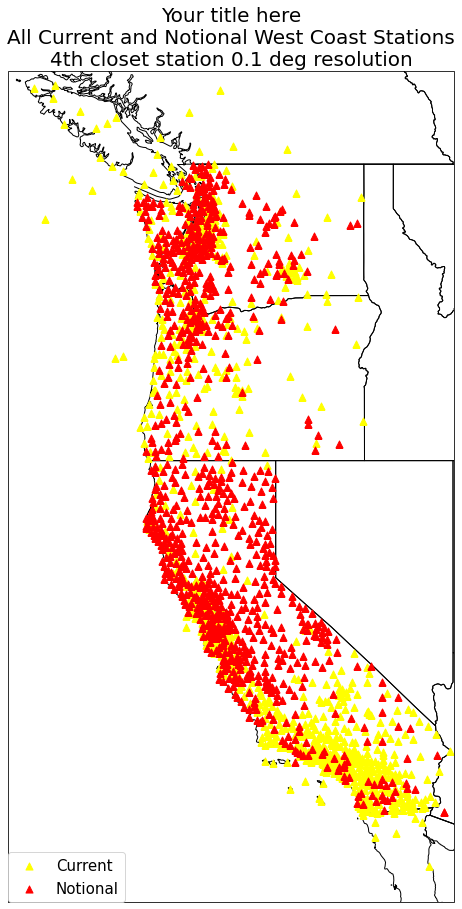

<Figure size 432x288 with 0 Axes>

In [58]:
#just plot the stas
path = wc_current_and_notional_travel_times.get_path()
%run -i scripts/plot_heatmap.py \
--path=$path \
--title1="Your title here" \
--title2="All Current and Notional West Coast Stations" \
--title3="4th closet station 0.1 deg resolution" \
--stas \
--color=viridis \
--lat_min=30 \
--lat_max=51 \
--lon_min=-129 \
--lon_max=-114 \
--plotwidth=8 \
--plotheight=30 \
--legend_pad=0

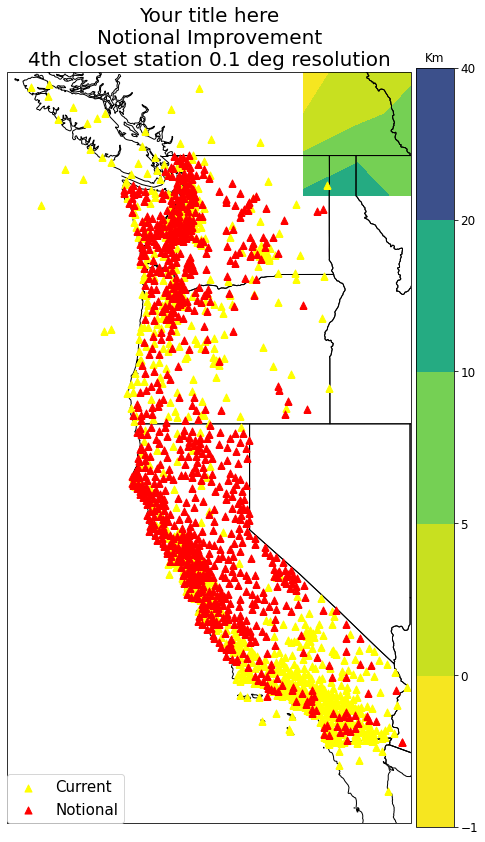

<Figure size 432x288 with 0 Axes>

In [59]:
path = diff_wc.get_path()
%run -i scripts/plot_heatmap.py \
--path=$path \
--title1="Your title here" \
--title2="Notional Improvement" \
--title3="4th closet station 0.1 deg resolution" \
--stas \
--color=viridis_r \
--levels=-1,0,5,10,20,40 \
--lat_min=30 \
--lat_max=51 \
--lon_min=-129 \
--lon_max=-114 \
--plotwidth=8 \
--plotheight=30 \
--legend_pad=0 \
--colorbar_pad=0.01 \
--colorbar_fraction=0.085